In [1]:
import mxnet as mx
import numpy as np

## MLP(Multilayer Perceptron)

In [2]:
def get_symbol_mlp(num_hiddens):
    '''
    get_symbol_mlp:    a function to create a Multilayer Perceptron symbol by mxnet.
    
    params:
    -------
    num_hidden:    array, the number of hidden units
    
    returns:
    --------
    mlp:    a mxnet symbol
    '''
    data = mx.sym.Variable('data')
    data = mx.sym.Flatten(data = data)
    for num in range(len(num_hiddens) - 1):
        fc = mx.sym.FullyConnected(data=data, num_hidden=num_hiddens[num], name='fc'+str(num+1))
        data = mx.sym.Activation(data=fc, act_type='tanh', name='relu'+str(num+1))
    fc_softmax = mx.sym.FullyConnected(data=data, num_hidden=num_hiddens[-1], name='fc'+str(len(num_hiddens)) )
    mlp = mx.sym.SoftmaxOutput(data = fc_softmax, name='softmax')
    return mlp

In [3]:
# get mnist hand written data
mnist = mx.test_utils.get_mnist()

# Parepare
batch_size = 128
train_iter = mx.io.NDArrayIter(data=mnist['train_data'], 
                               label=mnist['train_label'], 
                               batch_size=batch_size, 
                               shuffle=True)

eval_iter = mx.io.NDArrayIter(data=mnist['test_data'], 
                              label=mnist['test_label'], 
                              batch_size=batch_size, 
                              shuffle=False)

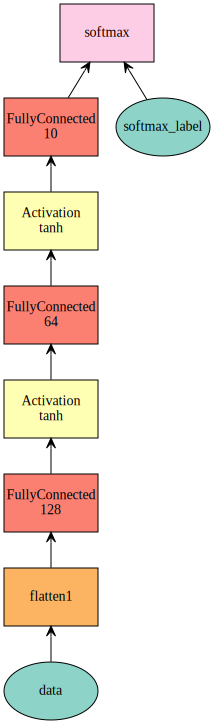

In [5]:
num_hiddens = [128, 64, 10]
mlp = get_symbol_mlp(num_hiddens=num_hiddens)
mx.viz.plot_network(mlp)

In [7]:
# Train
import logging
logging.getLogger().setLevel(logging.DEBUG)
# Create a trainable model on GPU
mlp_model = mx.mod.Module(symbol=mlp, context=mx.gpu())
mlp_model.fit(train_data=train_iter, 
              eval_data=eval_iter,
              force_init = True,
              optimizer='sgd', 
              optimizer_params={'learning_rate':0.1}, 
              eval_metric='acc', 
              batch_end_callback=mx.callback.Speedometer(batch_size, 128), 
              num_epoch=10)

INFO:root:Epoch[0] Batch [128]	Speed: 100632.14 samples/sec	accuracy=0.109314
INFO:root:Epoch[0] Batch [256]	Speed: 124402.34 samples/sec	accuracy=0.112793
INFO:root:Epoch[0] Batch [384]	Speed: 175708.65 samples/sec	accuracy=0.212036
INFO:root:Epoch[0] Train-accuracy=0.406064
INFO:root:Epoch[0] Time cost=0.464
INFO:root:Epoch[0] Validation-accuracy=0.471025
INFO:root:Epoch[1] Batch [128]	Speed: 164894.16 samples/sec	accuracy=0.608043
INFO:root:Epoch[1] Batch [256]	Speed: 138100.18 samples/sec	accuracy=0.772888
INFO:root:Epoch[1] Batch [384]	Speed: 155712.43 samples/sec	accuracy=0.835449
INFO:root:Epoch[1] Train-accuracy=0.848400
INFO:root:Epoch[1] Time cost=0.396
INFO:root:Epoch[1] Validation-accuracy=0.856705
INFO:root:Epoch[2] Batch [128]	Speed: 174702.69 samples/sec	accuracy=0.867248
INFO:root:Epoch[2] Batch [256]	Speed: 163252.43 samples/sec	accuracy=0.882568
INFO:root:Epoch[2] Batch [384]	Speed: 173075.99 samples/sec	accuracy=0.890625
INFO:root:Epoch[2] Train-accuracy=0.894903
INF

In [10]:
# Test
test_iter = mx.io.NDArrayIter(data=mnist['test_data'], 
                              label=mnist['test_label'], 
                              batch_size=batch_size, 
                              shuffle=False)
acc = mx.metric.Accuracy()
mlp_model.score(eval_data=test_iter, eval_metric=acc, reset=True)
print(acc)

EvalMetric: {'accuracy': 0.964003164556962}


## Lenet

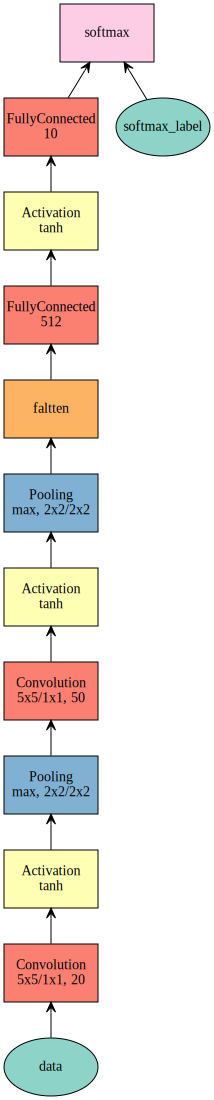

In [31]:
def get_symbol_lenet(num_classes):
    '''
    get_symbol_lenet:    a function to create a Lenet symbol by mxnet
    
    returns:
    --------
    
    '''
    input_data = mx.sym.Variable(name='data')
    
    # stage1
    conv1 = mx.sym.Convolution(data=input_data, kernel=(5, 5), stride=(1,1), num_filter=20, name='conv1')
    relu1 = mx.sym.Activation(data=conv1, act_type='tanh', name='relu1')
    #lrn1 = mx.sym.LRN(data=relu1, alpha=0.001, beta=0.75, knorm=2, nsize=5, name='lrn1')
    pool1 = mx.sym.Pooling(data=relu1, kernel=(2,2), stride=(2,2), pool_type='max', name='pool1')
    
    # stage2
    conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), stride=(1,1), num_filter=50, name='conv2')
    relu2 = mx.sym.Activation(data=conv2, act_type='tanh', name='relu2')
    # lrn2 = mx.sym.LRN(data=relu2, alpha=0.0001, beta=0.75, knorm=2, nsize=5, name='lrn2')
    pool2 = mx.sym.Pooling(data=relu2, kernel=(2,2), stride=(2,2), pool_type='max', name='pool2')
    
    # stage3
    flatten = mx.sym.Flatten(data=pool2, name='faltten')
    fc1 = mx.sym.FullyConnected(data=flatten, num_hidden=512, name='fc1')
    relu3 = mx.sym.Activation(data=fc1, act_type='tanh', name='relu3')
    # dropout1 = mx.sym.Dropout(data=relu3, p=0.5, name='dropout1')
    
    # stage4 加了这一层全连接层之后，网络没有学习能力
    #fc2 = mx.sym.FullyConnected(data=relu3, num_hidden=256, name='fc2')
    #relu4 = mx.sym.Activation(data=fc2, act_type='relu', name='relu4')
    # dropout2 = mx.sym.Dropout(data=relu4, p=0.7, name='dropout2')
    
    # stage5
    fc3 = mx.sym.FullyConnected( data=relu3, num_hidden=num_classes, name='fc3')
    lenet = mx.sym.SoftmaxOutput(data=fc3, name='softmax')
    
    return lenet

lenet = get_symbol_lenet(10)
mx.viz.plot_network(lenet)

In [32]:
# get mnist hand written data
mnist = mx.test_utils.get_mnist()

# Parepare
batch_size = 128
train_iter = mx.io.NDArrayIter(data=mnist['train_data'], 
                               label=mnist['train_label'], 
                               batch_size=batch_size, 
                               shuffle=True)

eval_iter = mx.io.NDArrayIter(data=mnist['test_data'], 
                              label=mnist['test_label'], 
                              batch_size=batch_size, 
                              shuffle=False)

INFO:root:train-labels-idx1-ubyte.gz exists, skip to downloada
INFO:root:train-images-idx3-ubyte.gz exists, skip to downloada
INFO:root:t10k-labels-idx1-ubyte.gz exists, skip to downloada
INFO:root:t10k-images-idx3-ubyte.gz exists, skip to downloada


In [33]:
import logging
logging.getLogger().setLevel(logging.DEBUG)
# create a trainable module on GPU
lenet_model = mx.mod.Module(symbol=lenet, context=mx.gpu())
lenet_model.fit(train_data=train_iter,
              eval_data=eval_iter,
              optimizer='sgd',
              optimizer_params={'learning_rate':0.1},
              eval_metric='acc',
              batch_end_callback=mx.callback.Speedometer(batch_size, 128),
              num_epoch=100)

INFO:root:Epoch[0] Batch [128]	Speed: 20737.28 samples/sec	accuracy=0.113069
INFO:root:Epoch[0] Batch [256]	Speed: 21288.44 samples/sec	accuracy=0.108337
INFO:root:Epoch[0] Batch [384]	Speed: 21583.17 samples/sec	accuracy=0.112244
INFO:root:Epoch[0] Train-accuracy=0.115513
INFO:root:Epoch[0] Time cost=2.829
INFO:root:Epoch[0] Validation-accuracy=0.113726
INFO:root:Epoch[1] Batch [128]	Speed: 21344.62 samples/sec	accuracy=0.114341
INFO:root:Epoch[1] Batch [256]	Speed: 21250.24 samples/sec	accuracy=0.108337
INFO:root:Epoch[1] Batch [384]	Speed: 21356.55 samples/sec	accuracy=0.323120
INFO:root:Epoch[1] Train-accuracy=0.806083
INFO:root:Epoch[1] Time cost=2.821
INFO:root:Epoch[1] Validation-accuracy=0.870154
INFO:root:Epoch[2] Batch [128]	Speed: 21172.14 samples/sec	accuracy=0.888687
INFO:root:Epoch[2] Batch [256]	Speed: 21240.38 samples/sec	accuracy=0.924377
INFO:root:Epoch[2] Batch [384]	Speed: 21252.27 samples/sec	accuracy=0.942810
INFO:root:Epoch[2] Train-accuracy=0.952474
INFO:root:Ep

INFO:root:Epoch[22] Time cost=2.772
INFO:root:Epoch[22] Validation-accuracy=0.990407
INFO:root:Epoch[23] Batch [128]	Speed: 21421.49 samples/sec	accuracy=0.997638
INFO:root:Epoch[23] Batch [256]	Speed: 21397.96 samples/sec	accuracy=0.998657
INFO:root:Epoch[23] Batch [384]	Speed: 21410.23 samples/sec	accuracy=0.997925
INFO:root:Epoch[23] Train-accuracy=0.997396
INFO:root:Epoch[23] Time cost=2.806
INFO:root:Epoch[23] Validation-accuracy=0.990111
INFO:root:Epoch[24] Batch [128]	Speed: 21403.02 samples/sec	accuracy=0.997759
INFO:root:Epoch[24] Batch [256]	Speed: 19440.69 samples/sec	accuracy=0.998840
INFO:root:Epoch[24] Batch [384]	Speed: 17880.06 samples/sec	accuracy=0.998169
INFO:root:Epoch[24] Train-accuracy=0.997861
INFO:root:Epoch[24] Time cost=3.119
INFO:root:Epoch[24] Validation-accuracy=0.990111
INFO:root:Epoch[25] Batch [128]	Speed: 18036.53 samples/sec	accuracy=0.998001
INFO:root:Epoch[25] Batch [256]	Speed: 18333.86 samples/sec	accuracy=0.999084
INFO:root:Epoch[25] Batch [384]	S

KeyboardInterrupt: 